In [ ]:
# https://tinyurl.com/cbk-2019-linear

# TODO:

1. Determine what this file does
2. Determine what a linearization of an MNIST network looks like
3. Determine what linear regions for a specific sample look like
4. Apply this code to grayscale CIFAR

In [17]:
# Import needed files and basic setup
import sys
sys.path.append('C:\Program Files\Python37\Lib\site-packages')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import torchvision

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from ipywidgets import Output
from IPython.display import display, Markdown, Latex, Math, clear_output

from sklearn.neighbors import NearestNeighbors

import math

import time

%matplotlib inline
#plt.ion()

In [18]:
# Hyperparameters
n_epochs = 200
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 100

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [19]:
# Load training and testing sets
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../MNIST/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../MNIST/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

# transform = torchvision.transforms.Compose(
#     [torchvision.transforms.Grayscale(1),
#      torchvision.transforms.ToTensor(),
#      torchvision.transforms.Normalize((0.5,), (0.5,))
#     ])

# trainset = torchvision.datasets.CIFAR10('../CIFAR/', train=True,
#                                         download=True, transform=transform)
# train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='../CIFAR/', train=False,
#                                        download=True, transform=transform)
# test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test,
#                                          shuffle=False, num_workers=2)



# CIFAR_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.conv = nn.Conv2d(1, 1, 3, padding=1)
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 55)
        self.fc3 = nn.Linear(55, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.conv(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)
    
    def forwardNolog_softmax(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.conv(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [32]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum, weight_decay=learning_rate)

In [33]:
train_losses = []
train_acc = []
train_counter = []
test_losses = []
test_acc = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [34]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            pred = output.data.max(1, keepdim=True)[1]
            correct = pred.eq(target.data.view_as(pred)).sum()
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.6f}'.format(
                  epoch, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader), loss.item(), 100. * correct / 64))
            
            train_losses.append(loss.item())
            train_acc.append(100. * correct / 64)
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [35]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc.append(100. * correct / len(test_loader.dataset))
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))

In [36]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 1 1, but got 2-dimensional input of size [1, 128] instead

ValueError: x and y must have same first dimension, but have shapes (201,) and (0,)

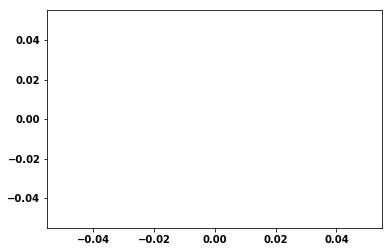

In [37]:
fig = plt.figure()
plt.plot(train_counter, train_acc, color='blue')
plt.plot(test_counter, test_acc, 'o', color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='lower right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [38]:
torch.save(network, 'MNISTRegularized.pt')

In [39]:
network = torch.load('MNISTRegularized.pt')

In [40]:
#Load training and testing with batch size 1
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../MNIST/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../MNIST/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1, shuffle=True)

# transform = torchvision.transforms.Compose(
#     [torchvision.transforms.Grayscale(1),
#      torchvision.transforms.ToTensor(),
#      torchvision.transforms.Normalize((0.5,), (0.5,))
#     ])

# trainset = torchvision.datasets.CIFAR10('../CIFAR/', train=True,
#                                         download=True, transform=transform)
# train_loader = torch.utils.data.DataLoader(trainset, batch_size=1,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='../CIFAR/', train=False,
#                                        download=True, transform=transform)
# test_loader = torch.utils.data.DataLoader(testset, batch_size=1,
#                                          shuffle=False, num_workers=2)



# CIFAR_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
CIFAROn = False

In [41]:
def computeAverage(net, data_loader, whichOut, doSoftmax=False):
    if CIFAROn:
        pixels = 1024
    else:
        pixels = 784
    numSamples = len(data_loader)
    graddamp = torch.zeros(1, pixels)
    outputs = np.zeros(numSamples)
    inputs = np.zeros((numSamples, pixels))
    correctlyLabeledAsThis = np.zeros(numSamples, dtype=np.bool)
    correctlyLabeledAsOther = np.zeros(numSamples, dtype=np.bool)
    incorrectlyLabeledAsThis = np.zeros(numSamples, dtype=np.bool)
    incorrectlyLabeledAsOther = np.zeros(numSamples, dtype=np.bool)
    
    outConsidering = torch.LongTensor([whichOut])
    
    for batch_idx, (data, target) in enumerate(data_loader):
        data.requires_grad_()
        net.zero_grad()
        
        if doSoftmax:
            output = net.forward(data)
        else:
            output = net.forwardNolog_softmax(data)
    
        g = torch.autograd.grad(output[:, whichOut], data)[0].data
        g = g.view(-1, pixels)
        
        graddamp += g
        outputs[batch_idx] = output[:, whichOut].detach().numpy()
        inputs[batch_idx, :] = data.view(-1, pixels).detach().numpy()
        
        outLabel = output.argmax()
        
        if torch.eq(outConsidering, outLabel):
            if torch.eq(target, outLabel):
                correctlyLabeledAsThis[batch_idx] = True
            else:
                incorrectlyLabeledAsThis[batch_idx] = True
        else:
            if torch.eq(target, outLabel):
                correctlyLabeledAsOther[batch_idx] = True
            elif torch.eq(target, outConsidering):
                incorrectlyLabeledAsOther[batch_idx] = True
        
        if (batch_idx+1) % 10000 == 0:
            print(batch_idx+1, '/', numSamples)

    #U, s, V = torch.svd(torch.mm(graddamp.t(), graddamp))
    w = graddamp/numSamples
    
    return w, inputs, outputs, correctlyLabeledAsOther, correctlyLabeledAsThis, incorrectlyLabeledAsOther, incorrectlyLabeledAsThis

In [42]:
def plotAverage(fig1, fig2, w, whichOut, inputs, outputs, correctlyLabeledAsOther, correctlyLabeledAsThis, incorrectlyLabeledAsOther, incorrectlyLabeledAsThis, doLogScale=True):
    nums = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
    #nums = CIFAR_labels
    ax1 = fig1.add_subplot(1, 2, 1)
    ax2 = fig2.add_subplot(1, 2, 2)
    im = ax1.imshow(w.reshape(28, 28), cmap='gray', interpolation='none', vmin=-0.1, vmax=0.1)#, vmin=0, vmax=255)
    #fig1.colorbar(im, ax=ax1)
    ax1.axis('off')
    ax1.set_title(nums[whichOut], fontsize=72)
    ax2.plot(np.matmul(inputs[correctlyLabeledAsOther, :], w.T), outputs[correctlyLabeledAsOther], '.', label='correct not {}'.format(whichOut), c='black', alpha=0.1)
    ax2.plot(np.matmul(inputs[correctlyLabeledAsThis, :], w.T), outputs[correctlyLabeledAsThis], '.', label='correct {}'.format(whichOut), c='green', alpha=0.1)
    ax2.plot(np.matmul(inputs[incorrectlyLabeledAsOther, :], w.T), outputs[incorrectlyLabeledAsOther], '.', label='incorrect label not {}'.format(whichOut), c='c', alpha=0.5)
    ax2.plot(np.matmul(inputs[incorrectlyLabeledAsThis, :], w.T), outputs[incorrectlyLabeledAsThis], '.', label='incorrect label {}'.format(whichOut), c='r', alpha=0.5)
    #ax2.plot(np.matmul(inputs, w.T), outputs, 'ko', alpha=0.5)
    ax2.set_xlabel(r'$w^T*x$')
    ax2.set_ylabel('Output {}'.format(nums[whichOut]))
    ax2.set_title('Output linearization for {}'.format(nums[whichOut]))
    #ax2.axis('off')
    leg = ax2.legend(fancybox=True, framealpha=0)
    for lh in leg.legendHandles: 
        lh._legmarker.set_alpha(1)
        lh._legmarker.set_markersize(20)

In [43]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

plt.rcParams.update({'font.size': 20})

nums = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
#nums = CIFAR_labels

ws = np.zeros((10, 784))
for whichOut in range(10):
    w, inputs, outputs, correctlyLabeledAsOther, correctlyLabeledAsThis, incorrectlyLabeledAsOther, incorrectlyLabeledAsThis = computeAverage(network, train_loader, whichOut, doSoftmax=False)
    ws[whichOut, :] = w.numpy()
    print(np.min(w.numpy()), np.max(w.numpy()))
    fig1 = plt.figure(figsize=(10, 15))
    fig2 = plt.figure(figsize=(15, 10))
    plotAverage(fig1,fig2,  w.numpy(), whichOut, inputs, outputs, correctlyLabeledAsOther, correctlyLabeledAsThis, incorrectlyLabeledAsOther, incorrectlyLabeledAsThis)
    fig1.canvas.draw()
    fig1.canvas.flush_events()
    fig2.canvas.draw()
    fig2.canvas.flush_events()
    
    plt.show()

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 1 1, but got 2-dimensional input of size [1, 128] instead

In [71]:
# Load training and testing sets
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../MNIST/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=60000, shuffle=False)


In [72]:
for data, target in test_loader:
    test_dataset = data.numpy()
    test_labels = target.numpy()
test_dataset = test_dataset.reshape(-1, 784)

In [73]:
out = np.matmul(ws, test_dataset.T)
labels = np.argmax(out, axis=0)
numEq = np.sum(test_labels == labels)
print(numEq/test_dataset.shape[0]*100, '% test accuracy')

84.45 % test accuracy


In [74]:
np.save('linearization.npy', ws)